In [100]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [101]:
import numpy as np
import pandas as pd

In [125]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [130]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, extract

In [104]:
# reflect an existing database into a new model
engine = create_engine("sqlite:///hawaii.sqlite")
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [105]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [106]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [107]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500.]),
 <a list of 7 Text xticklabel objects>)

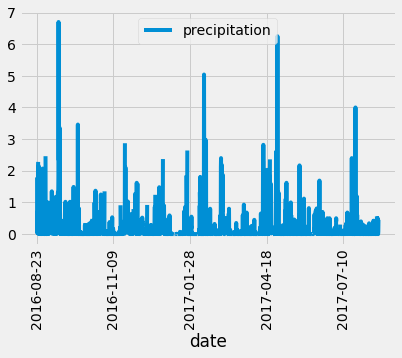

In [108]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
#Starting from the last data point in the database. 

# Calculate the date one year from the last date in data set.
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
#results = session.query(Measurement.date, Measurement.prcp)

#filter out the data anything greater than last year
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()

#print (results)
# Save the query results as a Pandas DataFrame and set the index to the date column
measurement_df = pd.DataFrame(results, columns=['date', 'precipitation']) 
measurement_df.set_index(measurement_df['date'], inplace=True)
# Sort the dataframe by date
measurement_df = measurement_df.sort_index()
#print(measurement_df.to_string(index=False))
dateList = pd.DataFrame(measurement_df.groupby(measurement_df['date'])['date'])[0].tolist()
# Use Pandas Plotting with Matplotlib to plot the data
ax = measurement_df.plot()
plt.xticks(rotation=90)


In [109]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measurement_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [110]:
# How many stations are available in this dataset?
station_count = session.query(func.count(Station.station)).all()
print (station_count)

[(9,)]


In [111]:
# What are the most active stations?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [112]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
#session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
#filter(Measurement.date >= prev_year).group_by(Measurement.station).all()

session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.date >= prev_year).filter(Measurement.station == 'USC00519281').all()

[('USC00519281', 59.0, 83.0, 73.10795454545455)]

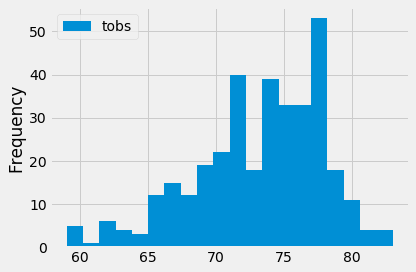

In [113]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs).\
filter(Measurement.date >= prev_year).filter(Measurement.station == 'USC00519281').all()
df = pd.DataFrame(results, columns=['tobs'])
df.plot.hist(bins=20)
plt.tight_layout()

In [126]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date=None, end_date=None):
    sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]

    if not end_date:
        results = session.query(*sel).\
            filter(Measurement.date <= start_date).all()
        temps = list(np.ravel(results))
        return jsonify(temps)
        
    results = session.query(*sel).\
        filter(Measurement.date >= start_date).\
            filter(Measurement.date <= end_date).all()
    
    temps = list(np.ravel(results))
    return temps

In [127]:
temps = calc_temps('2016-05-01', '2016-05-01')
print(temps)

[71.0, 79.0, 75.83333333333333]


# Challenge

In [153]:
#function to get temp statistics for all stations available 
#   for each station get the min,max and average temperatura for given month
def get_temp_stats_based_on_month( month):
    #get all station
    results =  session.query(Station.station).all()
    stations = list(np.ravel(results))
    sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
    stations_temp = dict()
    
    temp_stats_list = []
    for station in stations:
        results = session.query(*sel).\
            filter(Measurement.station == station).\
                filter(extract('month', Measurement.date) == month).all()
        temps = list(np.ravel(results))
        temp_stats_list.append(temps)
        
    temp_stats_df = pd.DataFrame(temp_stats_list, columns=['Min temp', 'Max temp', 'Avg temp'])
    return temp_stats_df

In [178]:
#get temperature statistics for all stations for the month of June
stations_temp_june_df = get_temp_stats_based_on_month(6)
stations_temp_june_df.head()

,Min temp,Max temp,Avg temp
0,70.0,84.0,77.559322
1,68.0,83.0,74.050847
2,67.0,81.0,76.005376
3,64.0,82.0,76.655405
4,67.0,78.0,73.394737


In [179]:
stations_temp_june_df.describe()

,Min temp,Max temp,Avg temp
count,9.000000,9.000000,9.000000
mean,67.111111,81.777778,74.853510
std,2.260777,2.223611,1.919588
min,64.000000,78.000000,71.937220
25%,66.000000,81.000000,73.394737
50%,67.000000,82.000000,74.139394
75%,68.000000,83.000000,76.655405
max,71.000000,85.000000,77.559322


In [182]:
#get temperature sttistics for all stations for the month of December
stations_temp_dec_df = get_temp_stats_based_on_month(12)
stations_temp_dec_df.head()

,Min temp,Max temp,Avg temp
0,56.0,77.0,71.109524
1,63.0,80.0,71.069444
2,62.0,79.0,73.224719
3,64.0,82.0,71.834862
4,63.0,78.0,72.421053


In [183]:
stations_temp_dec_df.describe()

,Min temp,Max temp,Avg temp
count,9.000000,9.000000,9.000000
mean,59.888889,79.777778,71.219070
std,3.218868,1.922094,1.376549
min,56.000000,77.000000,69.291262
25%,57.000000,79.000000,69.903226
50%,60.000000,79.000000,71.109524
75%,63.000000,81.000000,72.421053
max,64.000000,83.000000,73.224719


Text(0, 0.5, 'temperature')

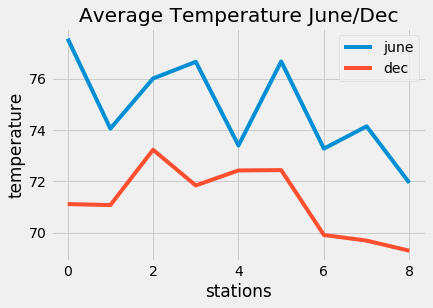

In [191]:
stations_temp_df = pd.DataFrame({'june': stations_temp_june_df['Avg temp'], 'dec': stations_temp_dec_df['Avg temp']})

ax = stations_temp_df.plot(kind='line', rot=0, title='Average Temperature June/Dec')
ax.set_xlabel('stations')
ax.set_ylabel('temperature')

In [158]:
#get total precipitation for the given month
def get_total_precip_based_on_month( month):
    #get all station
    results =  session.query(Station.station).all()
    stations = list(np.ravel(results))
    sel = [func.sum(Measurement.prcp)]
    stations_temp = dict()
    
    precp_list = []
    for station in stations:
        results = session.query(*sel).\
            filter(Measurement.station == station).\
                filter(extract('month', Measurement.date) == month).all()
        precp = list(np.ravel(results))
        precp_list.append(precp)
        
    precp_df = pd.DataFrame(precp_list, columns=['Sum prcp'])
    return precp_df

In [199]:
#get precp for all stations for the month of June
stations_precp_june_df = get_total_precip_based_on_month(6)
stations_precp_june_df.describe()

,Sum prcp
count,9.000000
mean,23.847778
std,33.040395
min,2.410000
25%,4.580000
50%,11.310000
75%,27.670000
max,106.090000


In [200]:
#get precp for all stations for the month of December
stations_precp_dec_df = get_total_precip_based_on_month(12)
stations_precp_dec_df.describe()

,Sum prcp
count,9.000000
mean,33.847778
std,29.211208
min,7.020000
25%,15.590000
50%,22.780000
75%,43.900000
max,99.880000


Text(0, 0.5, 'precipitation')

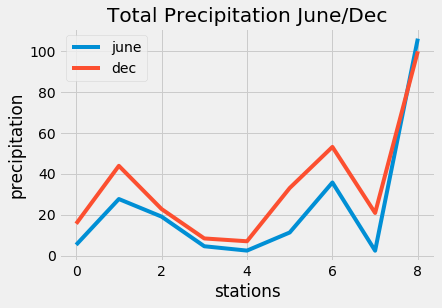

In [202]:
stations_precp_df = pd.DataFrame({'june': stations_precp_june_df['Sum prcp'], 'dec': stations_precp_dec_df['Sum prcp']})

ax = stations_precp_df.plot(kind='line', rot=0, title='Total Precipitation June/Dec')
ax.set_xlabel('stations')
ax.set_ylabel('precipitation')

# Analysis report (June , December data)

  December seems to be comparitively cooler than June where the temperature ranges between 59 - 79 degree celsius with average in 71 degree celcius, while June temperature ranges between 67 - 82 degree celcius with average in 75 degree celcius.<br>
  On top of temperature rain also plays a major role in the success of the business, average precipitation in the month of June is 24 cms while December seems to be rainy with 34 cms. With summer being the popular season not only for the families but also based on both temperature and precipitation, so it would be ideal to open Surf n Shake store during June